<h1>
<center>
Dataquest Guided Project 10:
Answering Business Questions using SQL 
</center>
</h1>

## Introduction

This is part of the Dataquest program.

- part of paths **Data Analyst in Python & Data Scientist in Python**
    - Step 4: **Working with data sources**
        - Course 2 : **SQL Intermediate : Table relations and joins **
            - Joining Data
            - Building and Organizing complex queries
            - Table relations and Normalization

As this is a guided project, we are following and deepening the steps suggested by Dataquest. In this project, we'll explore the Python SQLite workflow to explore, analyze, and visualize data from a database.

## Use case : the Chinook Database

The Chinook database contains information about a fictional digital music shop - kind of like a mini-iTunes store.
This database contains information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases. This information is contained in eleven tables. 
Here's a schema diagram for the Chinook database:
![Chinook db](https://s3.amazonaws.com/dq-content/191/chinook-schema.svg)




## Creating Helper Functions

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=2)
sns.set_palette('husl')
sns.set_style('white')

Let's create some reading function to save some time: 

In [2]:
database = "chinook.db"

def run_query(query):
    with sqlite3.connect(database) as conn:
        return pd.read_sql_query(query, conn)

def run_command(command):
    with sqlite3.connect(database) as conn:
        return conn.execute(command)


def show_tables(): 
    query = "SELECT name, type FROM sqlite_master WHERE type IN ('table', 'view')"
    return run_query(query)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Selecting albums to purchase

Let's say the Chinook record store has just signed a deal with a new record label, and we have been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now. Here are the names and genre of music they produce : 

| Artist Name | Genre   |
|------|------|
|   Regal |  Hip-Hop|
|   Red Tone |  Punk|
|   Meteor and the Girls |  Pop|
|   Slim Jim Bites |  Blues|

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we are interested in finding out which genres sell the best in the USA. 

In [3]:
album_query = '''
WITH usa_tracks_sold AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = "USA"
   )

SELECT
    g.name genre,
    count(uts.invoice_line_id) tracks_sold,
    cast(count(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks_sold
    ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''

genre_sales_usa = run_query(album_query)
genre_sales_usa

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


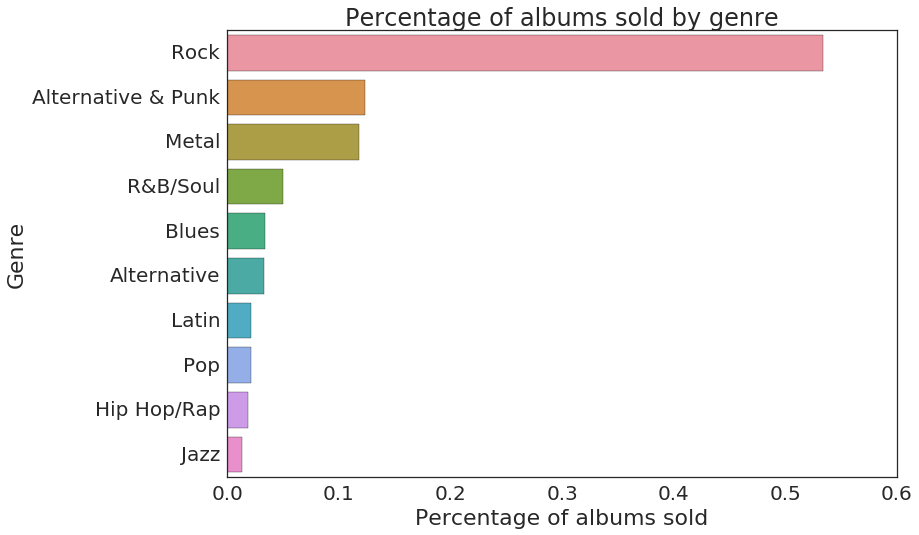

In [4]:
ax = plt.figure(figsize=(12,8))
ax = sns.barplot(x="percentage_sold", y="genre", data=genre_sales_usa);
ax.set(xlabel='Percentage of albums sold', ylabel='Genre',
       title= "Percentage of albums sold by genre");

However, among the four albums, the three we should add to our store are: 
    1. Red Tone (punk)
    2. Slim Jims Bites (blues)
    3. Meteor and the Girls (Pop)

However, rock is, by far, the most sold genre in the USA and account for more than 50% of the album sold. Thus, we should look for rock titles for our store.

## Analyzing Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [5]:
employee_query = '''
WITH customer_support_rep_sales AS
    (
    SELECT
        i.customer_id,
        c.support_rep_id,
        SUM(i.total) total
    FROM invoice i
    INNER JOIN customer c ON i.customer_id = c.customer_id
    GROUP BY 1,2
    )

SELECT
    e.first_name || " " || e.last_name employee,
    e.hire_date,
    SUM(csrs.total) total_sales
FROM customer_support_rep_sales csrs
INNER JOIN employee e ON e.employee_id = csrs.support_rep_id
GROUP BY 1
'''
employees = run_query(employee_query)
employees

,employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


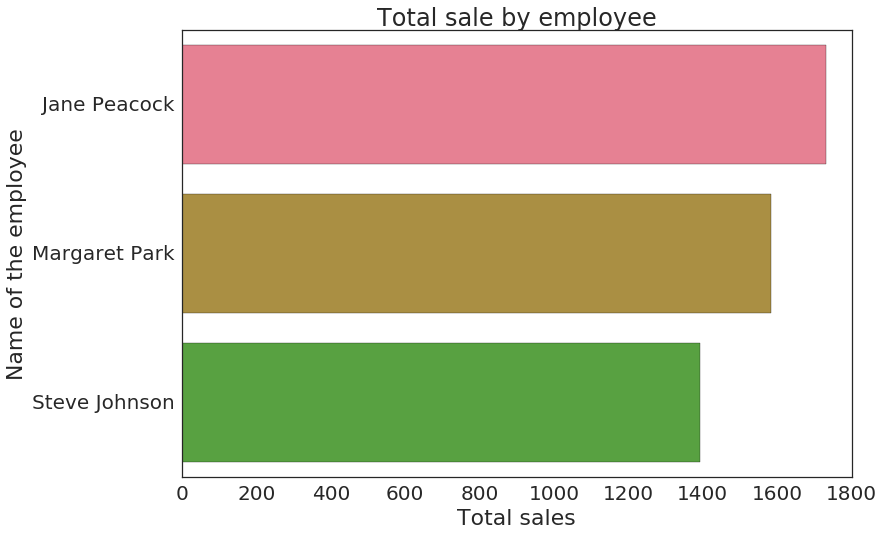

In [6]:
ax = plt.figure(figsize=(12,8))
ax = sns.barplot(x="total_sales", y="employee", data=employees);
ax.set(xlabel='Total sales', ylabel='Name of the employee',
       title= "Total sale by employee");

The three employees seem to perform almost equally. 
The top employee (Jane Peacock) performed 20% sales more than the bottom one (Steve Johnson). That can be explained by the hiring dates. 

## Analyzing Sales by Country

We now want to analyze the sale data for customers from each different country. Because there are a number of countries with only one customer, we will group these customers as "Other" in our analysis.

In [7]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

countries = run_query(sales_by_country)
countries

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


## Analyzing Sales by Country

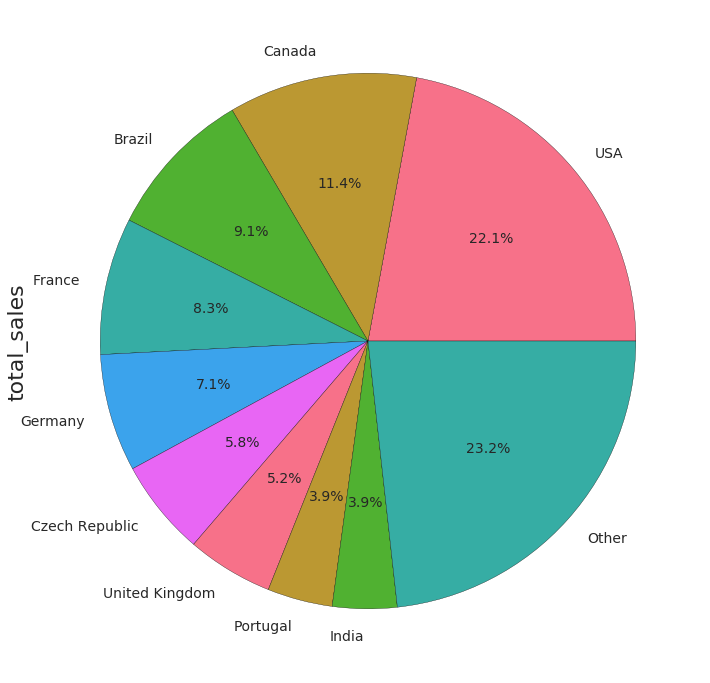

In [8]:
plt.figure(figsize=(12,12))
ax1 = plt.subplot(111, aspect='equal')

countries.plot(kind="pie", y="total_sales", labels=countries["country"],
              autopct='%1.1f%%', 
               shadow=False, legend = False, fontsize=14, ax=ax1);

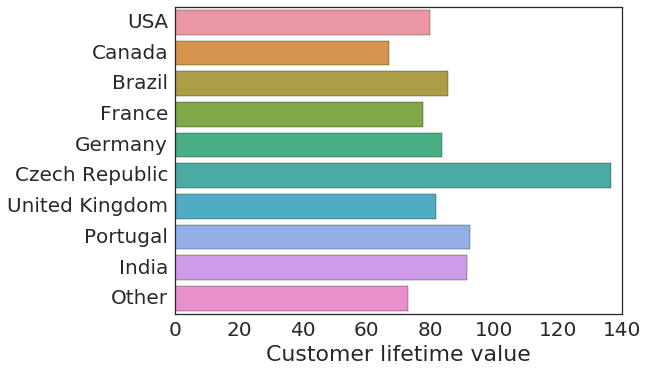

In [9]:
ax = sns.barplot(x="customer_lifetime_value", y="country", data=countries);
ax.set(xlabel='Customer lifetime value', ylabel='');

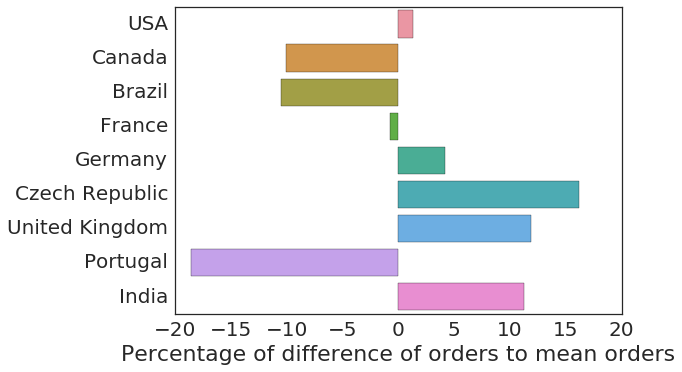

In [36]:
order_diff_mean = countries["average_order"].mean()
countries["order_diff_mean"] = countries["average_order"] *100 / order_diff_mean - 100
countries_no_other = countries[countries['country'] != "Other"]
ax = sns.barplot(x="order_diff_mean", y="country", data=countries_no_other);
ax.set(xlabel = "Percentage of difference of orders to mean orders", ylabel="");

The previous plots show us that there may be some opportunies to grow more sales in Czech Republic, United Kingdom, India and Germany.
As the product is new, it could be interesting to run a small campains in these countries. 

## Album vs Individual Tracks

The Chinook store is setup in a way that allows customer to make puchases in one of the two ways: 

- purchase a whole album
- purchase a collection of one or more individual tracks

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.
Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.
We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.
We have two edge cases to consider

- Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
- Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase.

In the first case, since our analysis is concerned with maximizing revenue we can safely ignore albums consisting of only a few tracks. The company has previously done analysis to confirm that the second case does not happen often, so we can ignore this case also.

In order to answer the question, we're going to have to identify whether each invoice has all the tracks from an album. We can do this by getting the list of tracks from an invoice and comparing it to the list of tracks from an album. We can find the album to compare the purchase to by looking up the album that one of the purchased tracks belongs to. It doesn't matter which track we pick, since if it's an album purchase, that album will be the same for all tracks.

In [37]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Album purchases account for 18.6% of purchases. It is not negligible, thus, to avoid losing 18.6% we recommend to keep both strategies. 